# 強化学習(Reinforcement Learning)

## Q学習
---
### 目的
講義で扱った強化学習の一つであるQ学習を用いて，エージェントが宝探しをするコードを記述する．
また，可視化のためのシミュレーション環境も自作する．
### 概要
エージェントは迷路の中を探索して宝物までの最適な経路を見つける．

- **状態**  
エージェントの位置：2次元

- **行動**  
上，下，左，右：4次元

- **報酬**  
宝が見つかったら，+100を与える  
それ以外は，ペナルティとして毎ステップ-1を与える

- **終了条件**  
宝が見つかる or 最大ステップ数(max_step)試行する  
（終了条件が成立すると1episodeが終了する）



---
### シミュレーション環境の作成
12×12マスのマップの中で行う

**シミュレーションの見方**
- 青色のマス：スタート位置
- 黒色のマス：壁
- 赤色の丸：現在のエージェントの位置
- 黄色の星：宝物（ゴール）

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

class MazeEnv(gym.Env):
    def __init__(self):
        self.action_list = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])

        self.map = np.array([["s", 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,  1 ],
                             [ 1 , 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,  1 ],
                             [ 0 , 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,  0 ],
                             [ 1 , 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,  1 ],
                             [ 1 , 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,  1 ],
                             [ 1 , 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,  1 ],
                             [ 1 , 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,  1 ],
                             [ 1 , 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,  1 ],
                             [ 1 , 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,  1 ],
                             [ 1 , 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,  1 ],
                             [ 1 , 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,  0 ],
                             [ 1 , 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, "g"]], dtype=object)

        action_num = 4
        self.action_space = gym.spaces.Discrete(action_num)
        self.max_position = [self.map.shape[1]-1, self.map.shape[0]-1]
        self.min_position = [0, 0]
        high = np.array(self.max_position, dtype=np.float32)
        low = np.array(self.min_position, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low, high, dtype=np.float32)
        
        self.fig = plt.figure(figsize=(7,7))
        self.ax = self.fig.add_subplot(111)

        self.time_step = 0
        self.total_reward = 0
        
        self.reset()

    def step(self, action_num):
        action = self.action_list[action_num]
        robot_position = self.state + action
        x, y = robot_position
        if x > self.max_position[1] or y > self.max_position[0] or x < self.min_position[1] or y < self.min_position[0]:
            pass
        elif self.map[y][x] != 0: 
            self.state = robot_position
        
        done = bool(self.map[self.state[0]][self.state[1]] == "g")

        if done:
            reward = 100
        else:
            reward = -1
        
        self.total_reward += reward
        self.time_step += 1
        
        return self.state, reward, done, {}

    def reset(self):
        self.time_step = 0
        self.total_reward = 0
        self.state = [0, 0]
        return self.state

    def render(self, episode_num):
        plt.xlim(0, self.map.shape[1])
        plt.ylim(0, self.map.shape[0])
        vgpoint = np.arange(0, self.map.shape[0], 1)
        hgpoint = np.arange(0, self.map.shape[1], 1)
        plt.vlines(vgpoint, 0, self.map.shape[0], linewidth=0.3)
        plt.hlines(hgpoint, 0, self.map.shape[1], linewidth=0.3)
        
        for y in range(self.map.shape[0]):
            for x in range(self.map.shape[1]):
                if self.map[y][x] == "s":
                    #plt.plot(x, y, marker="o", color="r", markersize=10, alpha = 0.9)
                    plt.axvspan(xmin=x, xmax=x+1, ymin=y/self.map.shape[0], ymax=(y+1)/self.map.shape[0], color = "c", alpha=0.5)
                    plt.text(x+0.5, y, "start", horizontalalignment='center', size=10, alpha=0.9, color="b")
                elif self.map[y][x] == "g":
                    plt.plot(x+0.5, y+0.5, marker="*", color="y", markersize=20, alpha = 0.9)
                elif self.map[y][x] == 0:
                    plt.axvspan(xmin=x, xmax=x+1, ymin=y/self.map.shape[0], ymax=(y+1)/self.map.shape[0], color = "k", alpha=0.9)
        
        plt.plot(self.state[0]+0.5, self.state[1]+0.5, marker="o", color="r", markersize=20, alpha = 0.9)

        plt.text(0.0, self.map.shape[0]+1.0, "%d episode" %episode_num, fontsize='x-large')
        plt.text(self.map.shape[1]-1.5, self.map.shape[0]+1.0, "time : %d" %self.time_step)
        plt.text(self.map.shape[1]-2.0, self.map.shape[0]+0.5, "reward : %d" %self.total_reward)

        plt.axis([0, self.map.shape[1], 0, self.map.shape[0]])
        self.ax.set_aspect('equal')
        clear_output(wait = True)
        plt.plot()
        display(self.fig)
        self.ax.cla()

---
### 学習
- Q学習のアルゴリズムで500episode学習を行いました．  
- 学習過程すべてをシミュレーションで可視化すると時間がかかるので，可視化するタイミグは調節可能にしてあります．  
  著者のPCで試したところ，100episodeに１回シミュレーションを動かすとおよそ2分程度かかります． （time_interval=100に設定） 
- 学習が終わると学習中の報酬の推移を表すグラフが出力されます．

**更新式**  
$α$：学習率, $γ$：割引率
$$ Q(s_t, a_t)←(1-α)Q(s_t, a_t)+α\bigl(r+γmax_{a_{t+1}}Q(s_{t+1}, a_{t+1})\bigr)$$

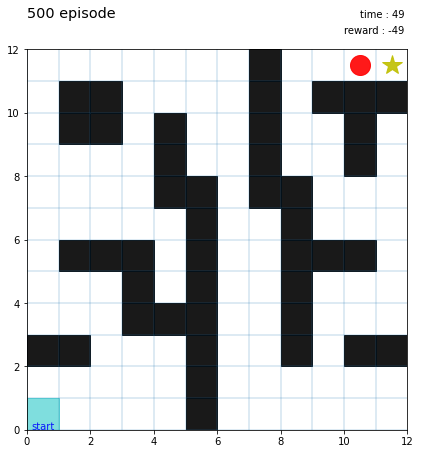

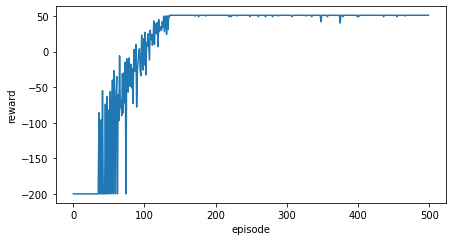

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def update_q_table(_q_table, _action, _state, _next_state, _reward, _episode):
    #Q(s, a) ←  Q(s, a) + α(r + γmaxQ(s', a') - Q(s, a))
    alpha = 0.5
    gamma = 0.99

    #行動後の状態で得られる最大行動価値Q(s', a')
    next_position_x, next_position_y = _next_state
    next_max_q_value = max(_q_table[next_position_x][next_position_y])

    #行動前の状態の行動価値Q(s, a)
    position_x, position_y = _state
    q_value = q_table[position_x][position_y][_action]

    #行動価値関数の更新
    _q_table[position_x][position_y][_action] = q_value + alpha * (_reward + gamma * next_max_q_value - q_value)
    
    return _q_table

def get_action(_env, _q_table, _state, _episode):
    #ε-greedy法
    epsilon = 0.002
    if np.random.uniform(0, 1) > epsilon:
        position_x, position_y = state
        _action = np.argmax(_q_table[position_x][position_y])
    else:
        _action = np.random.choice([0, 1, 2, 3])
    return _action

if __name__ == '__main__':
    env = MazeEnv()

    q_table = np.zeros((env.map.shape[1], env.map.shape[0], 4))

    state = env.reset()
    total_episode = 500
    max_step = 200
    time_interval = 100
    rewards = []
    x = []
    y = []

    print("{}episode Learning ...\n".format(total_episode))
    for episode in range(total_episode):
        total_reward = 0
        state = env.reset()

        for time_step in range(max_step):
            if (episode+1)%time_interval == 0 or episode == 0:
                env.render(episode+1)
            action = get_action(env, q_table, state, episode)
            next_state, reward, done, _ = env.step(action)

            q_table = update_q_table(q_table, action, state, next_state, reward, episode)
            total_reward += reward

            state = next_state

            if done:
                break
        
        if (episode+1)%time_interval == 0 or episode == 0:
            rewards.append(total_reward)
        x.append(episode)
        y.append(total_reward)

    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.plot(x, y)
    plt.show()